In [ ]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

# Style
import seaborn as sns
sns.set_style('whitegrid')

## getting data

In [3]:
# importing results from csv
texts_de = pd.read_csv('texts_de_20200226.csv', index_col=[0])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
texts_de.head()

,id,created_at,text,lang,score,date_only
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [8]:
# convert to datetime object
texts_de['date_only'] =  pd.to_datetime(texts_de['date_only'], format='%Y-%m-%d')

### moving average

In [11]:
texts_de_daily_count = texts_de.groupby(pd.Grouper(key='date_only',freq='D'))['id'].count()

In [12]:
texts_de_daily = texts_de.groupby(pd.Grouper(key='date_only',freq='D'))['score'].mean()

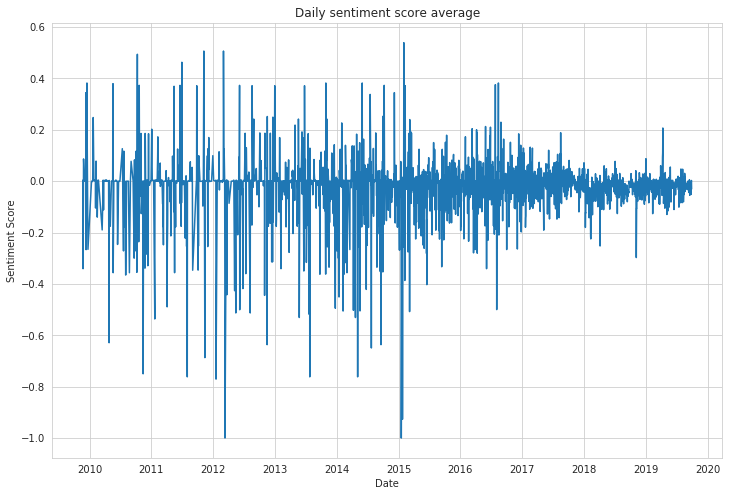

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()

In [30]:
# 3 day simple moving average
texts_de_daily_sma = texts_de_daily.rolling(3, min_periods=1).mean()

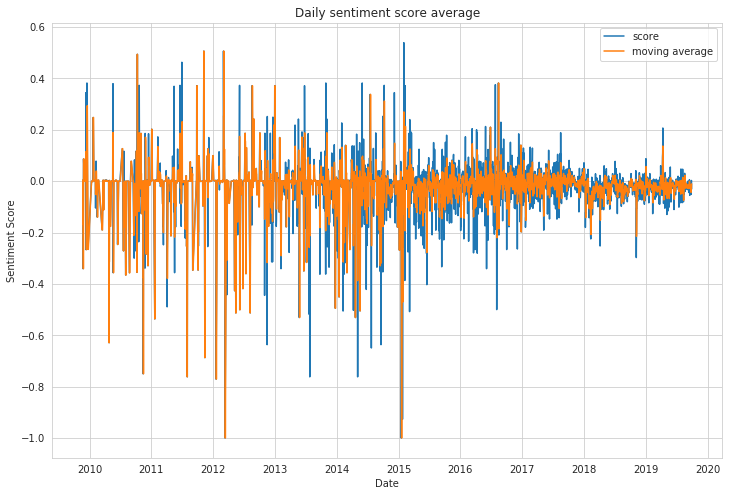

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax, label='score')
sns.lineplot(texts_de_daily_sma.index, texts_de_daily_sma, ax = ax, label='moving average')
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.legend()
plt.show()

In [ ]:
# 3 day cumulative moving average
texts_de_daily_sma = texts_de_daily.rolling(3).mean()

In [34]:
texts_de_daily_difference = texts_de_daily - texts_de_daily_sma

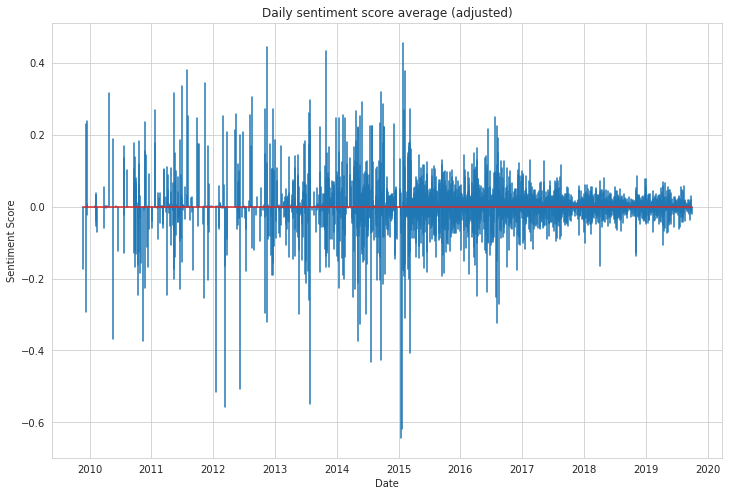

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
#sns.lineplot(texts_de_daily_difference.index, texts_de_daily_difference, ax = ax)
ax.stem(texts_de_daily_difference.index, texts_de_daily_difference, markerfmt=' ')
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average (adjusted)")
plt.show()
fig.savefig('plots/dailyavgsenti_adjusted.png', dpi=300)

### comparison to baseline

Set baseline text set as tweets before the establishment of the coal commission, analysis set as tweets after commission's establishment.

In [62]:
tweets_before = texts_de[texts_de['date_only'] < pd.Timestamp(2018,6,6)]
tweets_after = texts_de[texts_de['date_only'] >= pd.Timestamp(2018,6,6)] 

In [50]:
print(len(tweets_before),len(tweets_after))

63402 129569


In [44]:
len(texts_de)

193033

### topic modelling

In [51]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))

In [63]:
tweets_before_tm = tweets_before['text'].tolist()
tweets_after_tm = tweets_after['text'].tolist()

In [64]:
# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]

vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf_before = vectorizer.fit_transform(tweets_before_tm)
tfidf_after = vectorizer.fit_transform(tweets_after_tm)

In [65]:
tfidf_feature_names = vectorizer.get_feature_names()

In [66]:
K = 5

model_before = LDA(
    n_components=K, 
    random_state=123,
    doc_topic_prior=None, 
    topic_word_prior=None,
).fit(tfidf_before)

dtm_before = model_before.transform(tfidf_before)

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


NameError: name 'model' is not defined

In [68]:
model_after = LDA(
    n_components=K, 
    random_state=123,
    doc_topic_prior=None, 
    topic_word_prior=None,
).fit(tfidf_after)

dtm_before = model_after.transform(tfidf_after)

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


NameError: name 'model' is not defined

In [67]:
print_top_words(model_before, tfidf_feature_names, 10)


Topic #0:
httpstcohhfgdkqx getrag geschaff houellebeck epdost eeg bioenergi langweil antikohledemo lugd

Topic #1:
maria getrag pappnas gespalt gesund coemission braunkohledorf ahn neuig anikaschwalb

Topic #2:
getrag gipfeltreff daifko erziel funktionier drangt houellebeck fuhrend braunkohleabbau bildet

Topic #3:
gezielt gegenseit existenz flagg getrag gesund bedenkt gesetzentwurf rbbinforadio ran

Topic #4:
genial ckemfert kuckumbleibt gesund aufstand joch betroff hinein kugel be…



In [69]:
print_top_words(model_after, tfidf_feature_names, 10)


Topic #0:
rwe amp mehr braunkohl wald kohlekommission hambacherforst klimaschad zusamm endegela

Topic #1:
arminlaschet polit kohlefrei stopptdenwahnsinn nrw httpstcoszmwaqfcf braucht losung forst hambach

Topic #2:
kohleausstieg klimaschutz via kohlekommission kohl deutschland klimaziel schnell sagt vquaschning

Topic #3:
kohleausstieg kohlekommission ergebnis jahr cdu peteraltmai mehr schon energiew geht

Topic #4:
kohleausstieg kohl fridaysforfutur hambibleibt endegela klimaschutz klimakris heut kohlekommission fridayforfutur



In [71]:
model_before_nmf = NMF(
    n_components=K, 
    random_state=123,
    alpha=0.01, 
    l1_ratio=.91,
    init='nndsvd'
).fit(tfidf_before)

In [72]:
model_after_nmf = NMF(
    n_components=K, 
    random_state=123,
    alpha=0.01, 
    l1_ratio=.91,
    init='nndsvd'
).fit(tfidf_after)

In [73]:
print_top_words(model_before_nmf, tfidf_feature_names, 10)


Topic #0:
genial gesund maria ckemfert kuckumbleibt httpstcohhfgdkqx existenz gegenseit gezielt flagg

Topic #1:
getrag geschaff daifko gespalt houellebeck funktionier erziel ahn drangt beschutz

Topic #2:
aufstand joch betroff hinein getrag gezielt genial bedenkt kuckumbleibt heul

Topic #3:
gezielt flagg gesund ckemfert geschaff httpstcohhfgdkqx gegenseit houellebeck epdost bioenergi

Topic #4:
gesund pappnas neuig anikaschwalb coemission gespalt braunkohledorf beschadigt erpress ran



In [74]:
print_top_words(model_after_nmf, tfidf_feature_names, 10)


Topic #0:
rwe polit nrw unterstutz landesregier massiv interess verstandnis arminlaschet braucht

Topic #1:
kohleausstieg schnell mehr klimaschutz hambibleibt deutschland energiew kohl fridaysforfutur via

Topic #2:
mehr braunkohl arminlaschet davon klimaschad nrw zusamm kohlefrei verlass energietrag

Topic #3:
kohlekommission kohl klimaschutz rwe hambacherforst amp ergebnis hambibleibt fridaysforfutur endegela

Topic #4:
amp wald rett zeig polit konflikt raumung fuhrungsstark dien rweinteress



## word shift

In [76]:
tfidf_before

<63402x7025 sparse matrix of type '<class 'numpy.int64'>'
	with 554371 stored elements in Compressed Sparse Row format>

In [77]:
ws_vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=20000,
                             stop_words=stopword_list)

In [78]:
count_before = ws_vectorizer.fit_transform(tweets_before_tm)
count_after = ws_vectorizer.fit_transform(tweets_after_tm)

In [79]:
dtm_before = count_before.fit_transform(tfidf_after)

<63402x8501 sparse matrix of type '<class 'numpy.int64'>'
	with 685437 stored elements in Compressed Sparse Row format>

In [85]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    #vec = CountVectorizer().fit(corpus)
    vec = ws_vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [86]:
top_words_before = get_top_n_words(tweets_before_tm)
top_words_after = get_top_n_words(tweets_after_tm)

In [89]:
sample_before = top_words_before[0:1000]
sample_after = top_words_after[0:1000]

In [87]:
top_words_before[0:50]

[('https', 63065),
 ('kohleausstieg', 37548),
 ('kohlefrei', 28493),
 ('kohle', 26259),
 ('klima', 19445),
 ('eisbären', 15296),
 ('merkel', 15217),
 ('schützen', 14586),
 ('kanzlerin', 13932),
 ('stoppen', 12717),
 ('handeln', 11934),
 ('f8smsaqrsf', 10763),
 ('für', 9571),
 ('klimaschutz', 7273),
 ('http', 5767),
 ('via', 4302),
 ('beim', 4272),
 ('endcoal', 3950),
 ('brauchen', 3845),
 ('mehr', 3457),
 ('online', 3300),
 ('climate', 3260),
 ('amp', 3160),
 ('march', 3156),
 ('klimawandel', 3015),
 ('energiewende', 2902),
 ('deutschland', 2870),
 ('keine', 2543),
 ('mache', 2347),
 ('ohne', 2335),
 ('geht', 2215),
 ('müssen', 2074),
 ('ja', 2071),
 ('groko', 1989),
 ('unterzeichnen', 1924),
 ('gibt', 1912),
 ('aufgeben', 1889),
 ('klimaziele', 1873),
 ('stoppt', 1864),
 ('jamaika', 1848),
 ('eine', 1820),
 ('klimaziel', 1775),
 ('schützt', 1753),
 ('macht', 1692),
 ('raus', 1682),
 ('werden', 1681),
 ('campact', 1658),
 ('gegen', 1645),
 ('fordern', 1645),
 ('dafür', 1549)]

In [88]:
top_words_after[:50]

[('co', 83386),
 ('https', 83073),
 ('kohleausstieg', 63720),
 ('für', 38074),
 ('kohlekommission', 34178),
 ('rt', 33182),
 ('kohle', 24548),
 ('rwe', 19578),
 ('eine', 17382),
 ('arminlaschet', 15929),
 ('kohlefrei', 15220),
 ('stopptdenwahnsinn', 13437),
 ('klimaschutz', 13224),
 ('mehr', 12577),
 ('szmwaq9fcf', 12146),
 ('amp', 11584),
 ('hambacherforst', 11499),
 ('nrw', 11462),
 ('hambacher', 10753),
 ('hambibleibt', 10511),
 ('braucht', 9831),
 ('fridaysforfuture', 9594),
 ('lösung', 9273),
 ('forst', 9155),
 ('alle', 9079),
 ('politische', 9051),
 ('braunkohle', 8790),
 ('werden', 8689),
 ('einen', 6794),
 ('wald', 6705),
 ('einer', 6652),
 ('haben', 6421),
 ('deutschland', 6373),
 ('klima', 6032),
 ('habe', 5973),
 ('heute', 5756),
 ('davon', 5702),
 ('via', 5641),
 ('landesregierung', 5455),
 ('diesen', 5401),
 ('2038', 5368),
 ('über', 5275),
 ('energiewende', 5220),
 ('gegen', 5214),
 ('unterstützung', 5199),
 ('würde', 5184),
 ('zeigen', 5174),
 ('retten', 5153),
 ('intere

In [97]:
df_sample_before = pd.DataFrame(sample_before, columns=['word', 'count'])

In [99]:
df_sample_after = pd.DataFrame(sample_after, columns=['word', 'count'])

In [101]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [106]:
word_scores_before = []
for i in df_sample_before.index:
    entry = df_sample_before.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_before.append(score)

In [107]:
word_scores_after = []
for i in df_sample_after.index:
    entry = df_sample_after.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_after.append(score)

In [108]:
df_sample_before['score'] = word_scores_before
df_sample_after['score'] = word_scores_after

In [118]:
df_sample_before_scores = df_sample_before[pd.isnull(df_sample_before['score']) == False]
df_sample_after_scores = df_sample_after[pd.isnull(df_sample_after['score']) == False]

In [123]:
score_product_before = df_sample_before_scores['count']*df_sample_before_scores['score']
score_product_after = df_sample_after_scores['count']*df_sample_after_scores['score']

df_sample_before_scores['score product'] = score_product_before
df_sample_after_scores['score product'] = score_product_after

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [134]:
df_sample_before_scores =  df_sample_before_scores.rename(columns={"count": "count_before", "score product": "score_prod_bef"})
df_sample_after_scores = df_sample_after_scores.rename(columns={"count": "count_after", "score product": "score_prod_aft"})

In [136]:
df_sample_before_scores.sort_values(by=['score_prod_bef'])[:20]

,word,count_before,score,score_prod_bef
36,aufgeben,1889,-0.2098,-396.3122
81,unmöglich,1014,-0.3559,-360.8826
144,ende,502,-0.2088,-104.8176
484,streit,137,-0.6632,-90.8584
259,protest,253,-0.3564,-90.1692
422,kampf,156,-0.5372,-83.8032
400,gefährdet,163,-0.5006,-81.5978
365,problem,180,-0.3865,-69.5700
903,falsch,71,-0.7618,-54.0878
655,fehlt,100,-0.5365,-53.6500


In [137]:
df_sample_before_scores.sort_values(by=['score_prod_bef'], ascending=False)[:20]

,word,count_before,score,score_prod_bef
180,gut,380,0.3716,141.2080
295,wichtig,231,0.3822,88.2882
282,besser,236,0.3716,87.6976
303,gute,227,0.3716,84.3532
489,wichtiger,136,0.3822,51.9792
527,helfen,127,0.3730,47.3710
633,sicher,105,0.3733,39.1965
679,hilft,96,0.3730,35.8080
198,liebe,336,0.0985,33.0960
699,erfolg,92,0.3446,31.7032


In [138]:
df_sample_after_scores.sort_values(by=['score_prod_aft'])[:20]

,word,count_after,score,score_prod_aft
110,ende,2250,-0.2088,-469.8000
475,streit,596,-0.6632,-395.2672
283,blockieren,965,-0.3459,-333.7935
513,kampf,560,-0.5372,-300.8320
717,falsch,385,-0.7618,-293.2930
367,protest,750,-0.3564,-267.3000
426,problem,654,-0.3865,-252.7710
434,zerstörung,645,-0.3578,-230.7810
623,zerstört,442,-0.5131,-226.7902
642,kritik,424,-0.5308,-225.0592


In [139]:
df_sample_after_scores.sort_values(by=['score_prod_aft'], ascending=False)[:20]

,word,count_after,score,score_prod_aft
130,gut,1824,0.3716,677.7984
338,wichtig,797,0.3822,304.6134
349,besser,783,0.3716,290.9628
361,gute,761,0.3716,282.7876
396,möchte,699,0.3450,241.1550
491,sicher,573,0.3733,213.9009
131,schnell,1815,0.1169,212.1735
149,schneller,1684,0.1169,196.8596
599,wichtiger,463,0.3822,176.9586
951,besonders,278,0.5391,149.8698


### finding the differences

In [144]:
df_joined = df_sample_before_scores.merge(df_sample_after_scores, on="word")

In [146]:
df_joined["difference"] = df_joined['score_prod_aft'] - df_joined['score_prod_bef']

In [151]:
df_joined["difference_abs"] = df_joined["difference"].abs()

In [155]:
df_joined.sort_values(by='difference_abs', ascending=False)

,word,count_before,score_x,score_prod_bef,count_after,score_y,score_prod_aft,difference,difference_abs
6,gut,380,0.3716,141.2080,1824,0.3716,677.7984,536.5904,536.5904
4,ende,502,-0.2088,-104.8176,2250,-0.2088,-469.8000,-364.9824,364.9824
60,blockieren,78,-0.3459,-26.9802,965,-0.3459,-333.7935,-306.8133,306.8133
30,streit,137,-0.6632,-90.8584,596,-0.6632,-395.2672,-304.4088,304.4088
0,aufgeben,1889,-0.2098,-396.3122,602,-0.2098,-126.2996,270.0126,270.0126
63,falsch,71,-0.7618,-54.0878,385,-0.7618,-293.2930,-239.2052,239.2052
27,kampf,156,-0.5372,-83.8032,560,-0.5372,-300.8320,-217.0288,217.0288
14,wichtig,231,0.3822,88.2882,797,0.3822,304.6134,216.3252,216.3252
62,möchte,74,0.3450,25.5300,699,0.3450,241.1550,215.6250,215.6250
12,besser,236,0.3716,87.6976,783,0.3716,290.9628,203.2652,203.2652


In [152]:
df_joined.sort_values(by='difference')[:15]

,word,count_before,score_x,score_prod_bef,count_after,score_y,score_prod_aft,difference,difference_abs
4,ende,502,-0.2088,-104.8176,2250,-0.2088,-469.8000,-364.9824,364.9824
60,blockieren,78,-0.3459,-26.9802,965,-0.3459,-333.7935,-306.8133,306.8133
30,streit,137,-0.6632,-90.8584,596,-0.6632,-395.2672,-304.4088,304.4088
63,falsch,71,-0.7618,-54.0878,385,-0.7618,-293.2930,-239.2052,239.2052
27,kampf,156,-0.5372,-83.8032,560,-0.5372,-300.8320,-217.0288,217.0288
54,zerstört,83,-0.5131,-42.5873,442,-0.5131,-226.7902,-184.2029,184.2029
23,problem,180,-0.3865,-69.5700,654,-0.3865,-252.7710,-183.2010,183.2010
51,kritik,90,-0.5308,-47.7720,424,-0.5308,-225.0592,-177.2872,177.2872
9,protest,253,-0.3564,-90.1692,750,-0.3564,-267.3000,-177.1308,177.1308
58,angst,79,-0.5140,-40.6060,400,-0.5140,-205.6000,-164.9940,164.9940


In [153]:
df_joined.sort_values(by='difference', ascending=False)[:15]

,word,count_before,score_x,score_prod_bef,count_after,score_y,score_prod_aft,difference,difference_abs
6,gut,380,0.3716,141.2080,1824,0.3716,677.7984,536.5904,536.5904
0,aufgeben,1889,-0.2098,-396.3122,602,-0.2098,-126.2996,270.0126,270.0126
14,wichtig,231,0.3822,88.2882,797,0.3822,304.6134,216.3252,216.3252
62,möchte,74,0.3450,25.5300,699,0.3450,241.1550,215.6250,215.6250
12,besser,236,0.3716,87.6976,783,0.3716,290.9628,203.2652,203.2652
15,gute,227,0.3716,84.3532,761,0.3716,282.7876,198.4344,198.4344
10,schnell,249,0.1169,29.1081,1815,0.1169,212.1735,183.0654,183.0654
43,sicher,105,0.3733,39.1965,573,0.3733,213.9009,174.7044,174.7044
17,schneller,214,0.1169,25.0166,1684,0.1169,196.8596,171.8430,171.8430
33,wichtiger,136,0.3822,51.9792,463,0.3822,176.9586,124.9794,124.9794


In [165]:
df_wordshift = df_joined.sort_values(by='difference_abs', ascending=False)[:45]

In [167]:
polarity = []
for i in df_wordshift.index:
    entry = df_wordshift.loc[i]
    if entry['score_x'] > 0:
        word_polarity = "Positive"
    elif entry['score_x'] < 0:
        word_polarity = "Negative"
    polarity.append(word_polarity)

In [168]:
df_wordshift['polarity'] = polarity

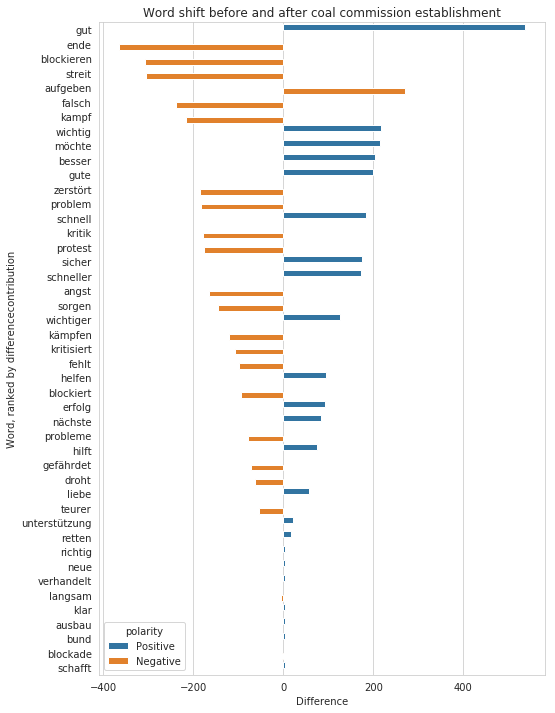

In [177]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(y='word',
            x='difference',
            hue='polarity',
            data=df_wordshift,
            ax = ax)
ax.set(xlabel="Difference",
       ylabel="Word, ranked by differencecontribution", 
       title="Word shift before and after coal commission establishment")
plt.show()